<a href="https://colab.research.google.com/github/Priyadharshini277/Deep-Learning-/blob/main/mlp_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train: (56000, 784)
Test: (14000, 784)
Epoch 1/20 | Loss=0.0708 | Acc=88.66%
Epoch 2/20 | Loss=0.0250 | Acc=90.98%
Epoch 3/20 | Loss=0.0234 | Acc=92.03%
Epoch 4/20 | Loss=0.0125 | Acc=92.83%
Epoch 5/20 | Loss=0.0158 | Acc=93.38%
Epoch 6/20 | Loss=0.0151 | Acc=93.99%
Epoch 7/20 | Loss=0.0134 | Acc=94.37%
Epoch 8/20 | Loss=0.0193 | Acc=94.86%
Epoch 9/20 | Loss=0.0191 | Acc=95.10%
Epoch 10/20 | Loss=0.0125 | Acc=95.54%
Epoch 11/20 | Loss=0.0030 | Acc=95.76%
Epoch 12/20 | Loss=0.0144 | Acc=95.88%
Epoch 13/20 | Loss=0.0072 | Acc=96.15%
Epoch 14/20 | Loss=0.0152 | Acc=96.35%
Epoch 15/20 | Loss=0.0138 | Acc=96.53%
Epoch 16/20 | Loss=0.0045 | Acc=96.69%
Epoch 17/20 | Loss=0.0054 | Acc=96.83%
Epoch 18/20 | Loss=0.0115 | Acc=96.97%
Epoch 19/20 | Loss=0.0032 | Acc=97.13%
Epoch 20/20 | Loss=0.0061 | Acc=97.30%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1343
           1       0.97      0.98      0.98      1600
   

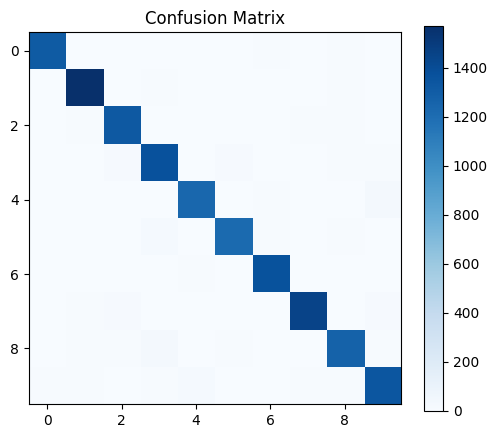

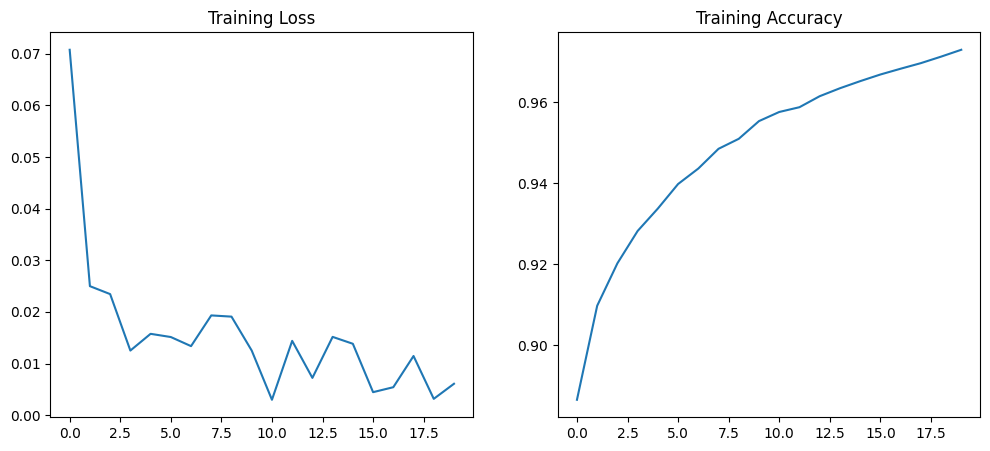

In [3]:
# ================================================
# PART A – MLP FROM SCRATCH (NUMPY ONLY)
# ================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# ---------------------------------------
# 1. Load MNIST Dataset
# ---------------------------------------
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist.data.astype("float32") / 255.0  # normalize
y = mnist.target.astype(int)

# One-hot encoding
y_onehot = np.eye(10)[y]

# Train–test split 80-20
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

# ---------------------------------------
# Activation Functions
# ---------------------------------------
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (s - 1)

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1 - np.tanh(x)**2

# Activation dictionary
ACT = {
    "relu": (relu, relu_deriv),
    "sigmoid": (sigmoid, sigmoid_deriv),
    "tanh": (tanh, tanh_deriv),
}

# ---------------------------------------
# 2. MLP Class From Scratch
# ---------------------------------------
class MLP:
    def __init__(self, act="relu", lr=0.01):
        self.lr = lr
        self.f, self.f_prime = ACT[act]

        # He/Xavier initialization
        self.W1 = np.random.randn(784, 128) * np.sqrt(2/784)
        self.b1 = np.zeros((1, 128))

        self.W2 = np.random.randn(128, 64) * np.sqrt(2/128)
        self.b2 = np.zeros((1, 64))

        self.W3 = np.random.randn(64, 10) * np.sqrt(2/64)
        self.b3 = np.zeros((1, 10))

    def softmax(self, z):
        exp = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    # Forward pass
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.f(self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.f(self.z2)

        self.z3 = self.a2 @ self.W3 + self.b3
        self.y_pred = self.softmax(self.z3)

        return self.y_pred

    # Backward pass
    def backward(self, X, y):
        m = y.shape[0]

        dz3 = self.y_pred - y
        dW3 = (self.a2.T @ dz3) / m
        db3 = np.sum(dz3, axis=0, keepdims=True) / m

        dz2 = (dz3 @ self.W3.T) * self.f_prime(self.z2)
        dW2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m

        dz1 = (dz2 @ self.W2.T) * self.f_prime(self.z1)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update
        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    # Training
    def train(self, X, y, epochs=20, batch=64):
        losses = []
        accs = []

        for e in range(epochs):
            perm = np.random.permutation(X.shape[0])
            X, y = X[perm], y[perm]

            for i in range(0, X.shape[0], batch):
                xb = X[i:i+batch]
                yb = y[i:i+batch]

                y_pred = self.forward(xb)
                loss = -np.mean(yb * np.log(y_pred + 1e-8))

                self.backward(xb, yb)

            # Track performance
            y_pred_full = self.forward(X)
            y_label = np.argmax(y_pred_full, axis=1)
            y_true = np.argmax(y, axis=1)
            acc = np.mean(y_label == y_true)

            losses.append(loss)
            accs.append(acc)

            print(f"Epoch {e+1}/{epochs} | Loss={loss:.4f} | Acc={acc*100:.2f}%")

        return losses, accs

# ---------------------------------------
# Train Model
# ---------------------------------------
model = MLP(act="relu", lr=0.01)
losses, accs = model.train(X_train, y_train, epochs=20)

# ---------------------------------------
# Evaluate on Test Data
# ---------------------------------------
y_pred = model.forward(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels))

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

# ---------------------------------------
# Plot Loss & Accuracy
# ---------------------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title("Training Loss")

plt.subplot(1,2,2)
plt.plot(accs)
plt.title("Training Accuracy")

plt.show()
